In [58]:
#Failide lugemiseks Colabis
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/Andmeteadus/Projekt/DataScienceProject")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
import pandas as pd
import numpy as np
import ast

from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU

import matplotlib.pyplot as plt

# Statistical classifier model

Building a RandomForestClassifier model to predict the "Artist Genre" value.

## Data processing

In [140]:
df1 = pd.read_csv("Standardized_data.csv", encoding="latin-1")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   float64
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   float64
 8   Spotify Playlist Count      4530 non-null   float64
 9   Spotify Playlist Reach      4528 non-null   float64
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   float64
 12  YouTube Likes               4285 non-null   float64
 13  TikTok Posts                3427 

In [141]:
# Converting "Release Date" to years and standardizing
df1["Release Date"] = pd.to_datetime(df1["Release Date"])
df1["Release Date"] = df1["Release Date"].dt.year

scaler = StandardScaler()
df1["Release Date"] = scaler.fit_transform(df1[["Release Date"]])

In [142]:
# Replacing numerical columns NaN values with the mean (0 because standardized)
num_cols = df1.select_dtypes(include="float64").columns
df1[num_cols] = df1[num_cols].replace(np.nan, 0)

In [143]:
# Keeping only top genres in "Artist Genres"
df1["Artist Genres"] = df1["Artist Genres"].apply(ast.literal_eval)

all_genres = [genre for sublist in df1["Artist Genres"] for genre in sublist]
genre_counts = Counter(all_genres)
top_genres = [genre for genre, count in genre_counts.items() if count > 5]

df1["Artist Genres"] = df1["Artist Genres"].apply(lambda genres: [genre for genre in genres if genre in top_genres])

In [144]:
# Multi-hot encoding "Artist Genres"
mlb = MultiLabelBinarizer()
multihot = pd.DataFrame(mlb.fit_transform(df1["Artist Genres"]), columns=mlb.classes_, index=df1.index)
df1 = pd.concat([df1, multihot], axis=1)

In [145]:
# Multi-hot encoding "Artist" and "Album Name"
artist_encoder = OneHotEncoder(sparse_output=False)
album_encoder = OneHotEncoder(sparse_output=False)

artist_encoded = artist_encoder.fit_transform(df1[["Artist"]])
album_encoded = album_encoder.fit_transform(df1[["Album Name"]])

artist_df = pd.DataFrame(artist_encoded, columns=artist_encoder.get_feature_names_out(["Artist"]))
album_df = pd.DataFrame(album_encoded, columns=album_encoder.get_feature_names_out(["Album Name"]))

#df1 = pd.concat([df1, artist_df], axis=1)
#df1 = pd.concat([df1, album_df], axis=1)

In [146]:
# Dropping unecessary columns

#drop = ["Track", "Album Name", "Artist", "ISRC", "Artist Genres", "Streams", "Views", "Likes", "Playlist Count", "Playlist Reach"]

drop = ["Track", "Album Name", "Artist", "ISRC", "Artist Genres",
    "Spotify Streams", "Spotify Playlist Count", "Spotify Playlist Reach",
    "YouTube Views", "YouTube Likes", "TikTok Likes", "TikTok Views", "YouTube Playlist Reach",
    "Apple Music Playlist Count", "AirPlay Spins", "SiriusXM Spins", "Deezer Playlist Count", "Deezer Playlist Reach", "Amazon Playlist Count",
    "Pandora Streams", "Pandora Track Stations", "Soundcloud Streams"]

df1 = df1.drop(columns=drop)

In [147]:
# Converting "Explicit Track" into int
df1["Explicit Track"] = df1["Explicit Track"].astype(int)

In [148]:
# Splitting into train and test sets
X = df1.drop(columns=["Explicit Track"])
y = df1["Explicit Track"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Building and training the model

In [150]:
model1 = RandomForestClassifier(n_estimators=100)
model1.fit(X_train, y_train)

RandomForestClassifier()

## Predicting and testing

In [151]:
y_pred = model1.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc}")
print()
print(report)

Accuracy: 0.7652173913043478

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       584
           1       0.77      0.51      0.62       336

    accuracy                           0.77       920
   macro avg       0.77      0.71      0.72       920
weighted avg       0.77      0.77      0.75       920



# Neural link classifier model

Building a neural link model to predict the "Artist Genre" value.

## Data processing

In [167]:
df2 = df1.copy()

In [168]:
# Splitting into train and test sets
X = df2.drop(columns=["Explicit Track"])
y = df2["Explicit Track"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

inputshape = X_train.shape[1]

## Building and training the model

In [154]:
model2 = Sequential()
model2.add(Input(shape=(inputshape,)))

#model2.add(Dense(128, activation="relu"))
model2.add(Dense(64, activation="relu"))
model2.add(Dense(32, activation="relu"))
model2.add(Dense(16, activation="relu"))

model2.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.0005)
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [169]:
model2 = Sequential()
model2.add(Input(shape=(inputshape,)))

model2.add(Dense(128, activation="relu"))
model2.add(LeakyReLU(negative_slope=0.1))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(64, activation="relu"))
model2.add(LeakyReLU(negative_slope=0.1))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

model2.add(Dense(32, activation="relu"))
model2.add(Dense(16, activation="relu"))

model2.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.0005)
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [170]:
epochs = 20
batchsize = 8
verbose = 1
hist = model2.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, verbose=verbose, validation_data=(X_val, y_val))

Epoch 1/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6104 - loss: 0.6618 - val_accuracy: 0.7014 - val_loss: 0.5853
Epoch 2/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6949 - loss: 0.5732 - val_accuracy: 0.7435 - val_loss: 0.5328
Epoch 3/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7129 - loss: 0.5548 - val_accuracy: 0.7551 - val_loss: 0.4979
Epoch 4/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7278 - loss: 0.5370 - val_accuracy: 0.7536 - val_loss: 0.4878
Epoch 5/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7346 - loss: 0.5152 - val_accuracy: 0.7696 - val_loss: 0.4876
Epoch 6/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7400 - loss: 0.4958 - val_accuracy: 0.7754 - val_loss: 0.4897
Epoch 7/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7504 - loss: 0.4908 - val_accuracy: 0.7812 - val_loss: 0.4788
Epoch 8/20
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7390 - loss: 0.4963 - val_accuracy: 0.

## Predicting and testing

In [171]:
print(f"Loss: {hist.history["loss"][-1]}")
print(f"Accuracy: {hist.history["accuracy"][-1]}")

Loss: 0.45562419295310974
Accuracy: 0.7757763862609863


In [172]:
y_pred = (model2.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc}")
print()
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7753623188405797

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       442
           1       0.76      0.54      0.64       248

    accuracy                           0.78       690
   macro avg       0.77      0.72      0.74       690
weighted avg       0.77      0.78      0.76       690



# Graphs

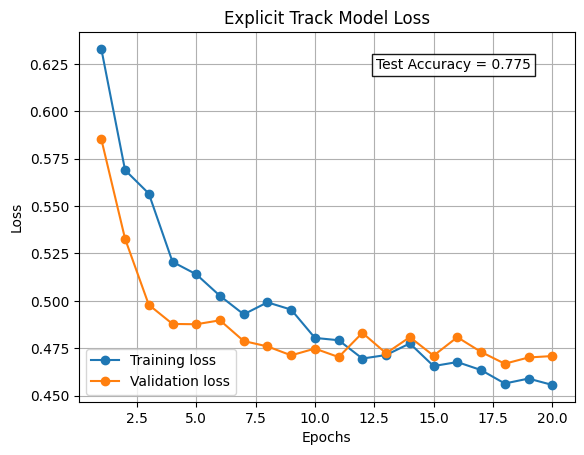

In [173]:
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
epoch_range = range(1, epochs+1)

plt.figure()
plt.plot(epoch_range, train_loss, label="Training loss", marker="o")
plt.plot(epoch_range, val_loss, label="Validation loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Explicit Track Model Loss")
plt.legend()
plt.grid(True)

plt.text(
    0.6, 0.9,
    f"Test Accuracy = {acc:.3f}",
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="square", facecolor="white", alpha=0.9)
)

plt.show()